<a href="https://colab.research.google.com/github/rbsathish/Detect_Changes_using_Deeplearning/blob/master/finding_defects_using_vgg19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd '/content/gdrive/My Drive/dataset/switchon'

/content/gdrive/My Drive/dataset/switchon


In [ ]:
# loading image 
img_1 = '/content/gdrive/My Drive/dataset/switchon/good_image.png'
img_2 = '/content/gdrive/My Drive/dataset/switchon/bad_image.png'

In [ ]:
# for tf 1.x 
# import tensorflow as tf
# import tensorflow.compat.v1 as tfc
# sess = tfc.InteractiveSession()
%tensorflow_version 1.x

TensorFlow 1.x selected.


Imports

In [ ]:
import tensorflow as tf
import keras
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import sys
from skimage import filters #change to 'import filter' for Python>v2.7
from skimage import exposure
from keras import backend as K

Using TensorFlow backend.


Activation Function


In [ ]:
#Function to retrieve features from intermediate layers
def get_activations(model, layer_idx, X_batch):
    get_activations = K.function([model.layers[0].input, K.learning_phase()], [model.layers[layer_idx].output,])
    activations = get_activations([X_batch,0])
    return activations

Model

In [ ]:
#Function to extract features from intermediate layers
def extra_feat(img_path):
	#Using a VGG19 as feature extractor
	base_model = VGG19(weights='imagenet',include_top=False)
	# img = image.load_img(img_path, target_size=(224, 224))
	x = image.img_to_array(img_path)
	x = np.expand_dims(x, axis=0)
	x = preprocess_input(x)
	block1_pool_features=get_activations(base_model, 3, x)
	block2_pool_features=get_activations(base_model, 6, x)
	block3_pool_features=get_activations(base_model, 10, x)
	block4_pool_features=get_activations(base_model, 14, x)
	block5_pool_features=get_activations(base_model, 18, x)

	x1 = tf.image.resize_images(block1_pool_features[0],[112,112])
	x2 = tf.image.resize_images(block2_pool_features[0],[112,112])
	x3 = tf.image.resize_images(block3_pool_features[0],[112,112])
	x4 = tf.image.resize_images(block4_pool_features[0],[112,112])
	x5 = tf.image.resize_images(block5_pool_features[0],[112,112])
	
	F = tf.concat([x3,x2,x1,x4,x5],3) #Change to only x1, x1+x2,x1+x2+x3..so on, inorder to visualize features from diffetrrnt blocks
	return F

Data

In [ ]:
def main():

  #Two aerial patches with change or No change
  img_path1= '/content/gdrive/My Drive/dataset/switchon/good_image.png' #'C:\\Users\\Dell\\Desktop\\interview\\switchon\\repo\\good_image.png '
  img_path2= '/content/gdrive/My Drive/dataset/switchon/bad_image.png' #'C:\\Users\\Dell\\Desktop\\interview\\switchon\\repo\\bad_image.png '
  img1 = image.load_img(img_path1, target_size=(224, 224))
  img2 = image.load_img(img_path2, target_size=(224, 224))
  
  # import tensorflow as tf
  # import tensorflow.compat.v1 as tfc
  sess = tf.InteractiveSession()

  #similar to Siamese network method
  #Sending images to Model for features
  F1=extra_feat(img1) #Features from image patch 1
  F1=tf.square(F1)
  F2=extra_feat(img2) #Features from image patch 2
  F2=tf.square(F2)

  #subracting the both image features 
  d=tf.subtract(F1,F2)
  d=tf.square(d) 
  d=tf.reduce_sum(d,axis=3) 

  dis=(d.eval())   #The change map formed showing change at each pixels
  dis=np.resize(dis,[112,112])
  # print(dis.shape)

  #resize the input image to plot like same aspect of outputs
  img1_re = image.load_img(img_path1, target_size=(112, 112))
  img2_re = image.load_img(img_path2, target_size=(112, 112))
  print(img1_re)
  plt.title('Good_image')
  plt.imshow(img1),plt.title('Good_image')
  plt.show()
  plt.title('Bad_image')
  plt.imshow(img2)
  plt.show()
  


  # Calculating threshold using Otsu's Segmentation method
  val = filters.threshold_otsu(dis[:,:])
  hist, bins_center = exposure.histogram(dis[:,:],nbins=256)
  

  
  #ploting the Detected defects from the model_output 
  plt.subplot(121),plt.imshow(dis, cmap='gray'),plt.title('Defects_Detected_by_VGG19')
  plt.subplot(122),plt.imshow(dis[:,:] < val, cmap='gray', interpolation='bilinear'),plt.title('Major_Different')
  plt.show()

  # #ploting the majaor change
  # plt.title('Defect Detected')
  # plt.imshow(dis[:,:] < val, cmap='gray', interpolation='bilinear')
  # plt.axis('off')
  # plt.tight_layout()
  # plt.show()





/tensorflow-1.15.2/python3.6/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


<PIL.Image.Image image mode=RGB size=112x112 at 0x7F70E7B13E80>


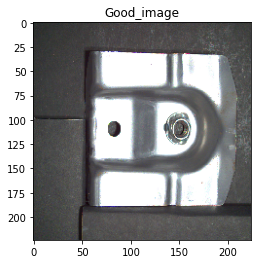

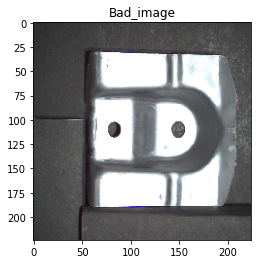

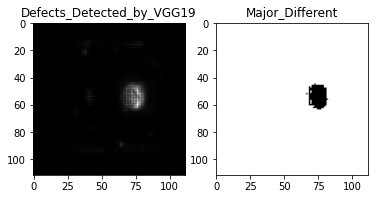

In [ ]:
if __name__ == "__main__":
    main()